**How can we accurately predict individual customer preferences and needs?**

- Develop a recommendation system to suggest relevant products and services.
- Identify key factors influencing customer preferences

In [1]:
# libraries
import numpy as np
import pandas as pd
from pandas.api.types import is_object_dtype

from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split

from lightfm import LightFM

c:\Users\anncy\anaconda3\envs\default\Lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [60]:
%run ./DataCleaning.ipynb

**Product Options**

Each product has 7 customizable options selected by customers, each with 2, 3, or 4 ordinal values possible:

A product is simply a vector with length 7 whose values are chosen from each of the options listed above. The cost of a product is a function of both the product options and customer characteristics.

In [62]:
# load datasets
bank_churners = load_data('BankChurners.csv') # main dataset
insurance_products = load_data('InsuranceProduct.csv') # dataset with different products and services

# merge datasets
df = bank_churners.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 
                         'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
                         axis=1) 	

# fill na values for risk factor with median and 0 for everything else
cols_to_merge = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'risk_factor']
insurance_products['risk_factor'] = insurance_products['risk_factor'].fillna(insurance_products['risk_factor'].median()) 
insurance_products = insurance_products[cols_to_merge].fillna(0)

col_limits = {'A': [0, 2], 'B': [0, 1], 'C': [1, 4], 'D': [1, 3], 'E': [0, 1], 'F': [0, 3], 'G': [1, 4], 'risk_factor': [0, None]}
for col in cols_to_merge:
    df = generate_new_data(df, insurance_products, col, lowerlim=col_limits[col][0], upperlim=col_limits[col][1])
    if col != 'cost':
        df[col] = np.round(df[col]).astype(int)

In [63]:
df.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,A,B,C,D,E,F,G,risk_factor
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,...,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,...,0.712222,0.274894,0.949640,0.482868,2.342451,2.273329,0.476153,1.268391,2.317764,2.737731
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,...,0.238086,0.275691,0.814659,0.499731,1.120631,0.808399,0.499456,1.087088,1.084675,1.353389
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,...,0.582000,0.023000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,2.000000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,...,0.702000,0.176000,1.000000,0.000000,2.000000,3.000000,0.000000,1.000000,2.000000,3.000000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,...,0.818000,0.503000,2.000000,1.000000,3.000000,3.000000,1.000000,2.000000,3.000000,4.000000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,...,3.714000,0.999000,2.000000,1.000000,4.000000,3.000000,1.000000,3.000000,4.000000,7.000000


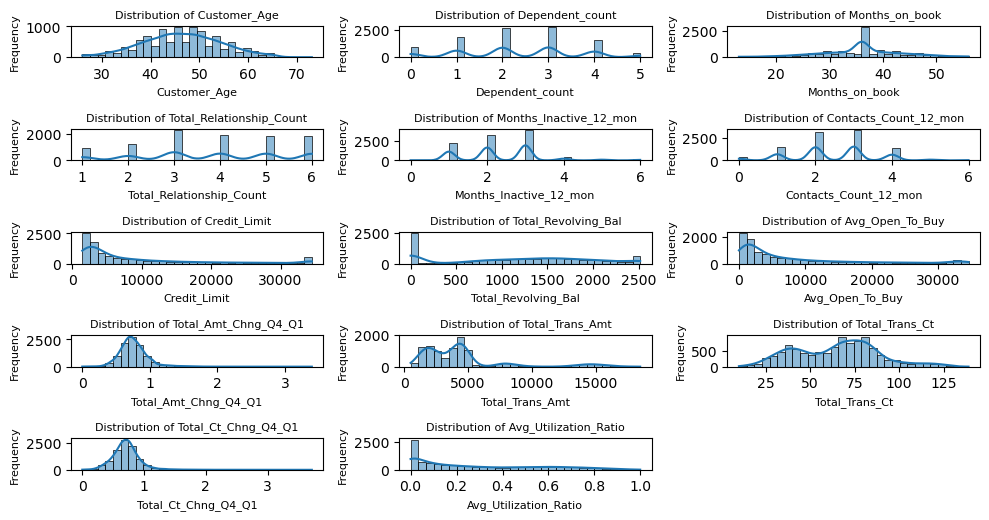

In [65]:

# drop irrelevant column
cols_to_drop = ['CLIENTNUM', 'Attrition_Flag', 'Months_on_book', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1']
df_clean = df.drop(columns=cols_to_drop)

categorical_columns = ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
levels = {'Education_Level': ['Unknown', 'Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate'
 'Doctorate'],
          'Income_Category': ['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +', 'Unknown'],
          'Card_Category': ['Blue', 'Silver', 'Gold', 'Platinum']}

# transform data to appropriate type
for col in df_clean.columns:
    if is_object_dtype(df[col]):
        if col in levels.keys():
            df_clean[col] = pd.Categorical(df[col], categories=levels[col], ordered=True)

        else:
            df_clean[col] = df_clean[col].astype('string')

In [66]:
# normalise data
#scaler = StandardScaler()
#train = scaler.transform(data)

In [68]:
# gradient boosting decision tree with logistic regression
product_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
features_list = list(set(df.columns).difference(set(product_list)))

train = df_clean
X = pd.get_dummies(df_clean.drop(columns=product_list))

pred = {}
for i in product_list:
    if train[i].nunique() == 2: # check what condition this is
        y = train[i]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

        gbdt_model = GradientBoostingClassifier(n_estimators=300,  # Number of boosting stages
                                                learning_rate=0.1,  
                                                max_depth=3, 
                                                random_state=123) 
        gbdt_model.fit(X_train, y_train)
        
        features = gbdt_model.apply(X_train)[:, :, 0]
    
        # train the LR model using the GBDT generated features
        lr_model = LogisticRegression(solver='lbfgs', C=1.0, random_state=123)

        lr_model.fit(features, y_train)
    
        # generate LR features
        gbdt_features_test = gbdt_model.apply(X_test)[:, :, 0]
        lr_features = lr_model.predict_proba(gbdt_features_test)[:, 1]
    
        # store the predicted score for the product
        pred[i] = lr_features
    
    else: 
        pass

pred = pd.DataFrame(pred)
test_gbdt = pd.concat([X_test.reset_index(names = 'cust_id'), pred],axis = 1, ignore_index = True)

col_list = ['cust_id'] + list(X_test.columns) + list(pred.columns)
test_gbdt.columns = col_list
test_gbdt['cust_id'] = test_gbdt['cust_id'].astype('string')

c:\Users\anncy\anaconda3\envs\default\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\anncy\anaconda3\envs\default\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\anncy\anaconda3\envs\default\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\anncy\anaconda3\envs\default\Lib\site-packages\sklearn\base.py:457: UserWarning: X has fea

In [ ]:
# collaborative filtering model: matrix factorisation algorithm




In [ ]:
# content based filtering model: knn
knn = NearestNeighbors(metric='cosine')
knn.fit(X)

distances, indices = knn.kneighbors()

In [ ]:
# hybrid: lightfm
model = LightFM(loss='warp')
model.fit()
